In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# PREPARE DATA FOR NEURAL NETWORK
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

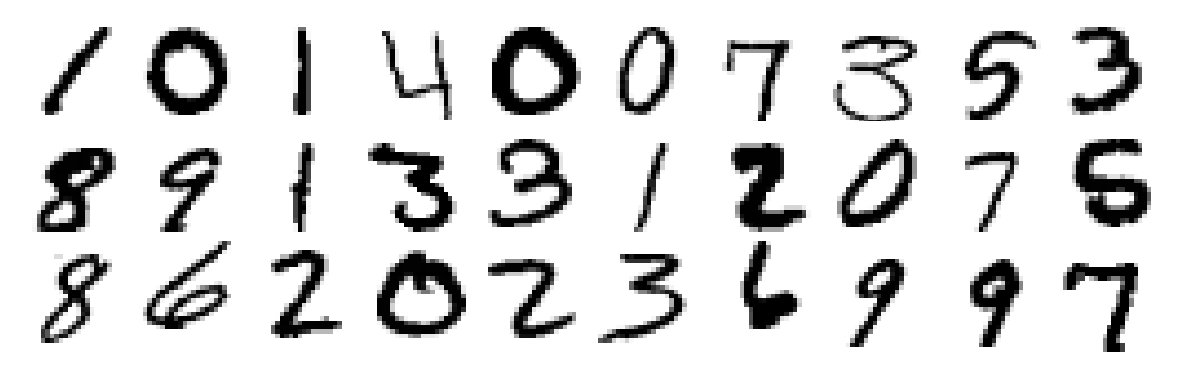

In [4]:
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [5]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.10,
        width_shift_range=0.1,
        height_shift_range=0.1)

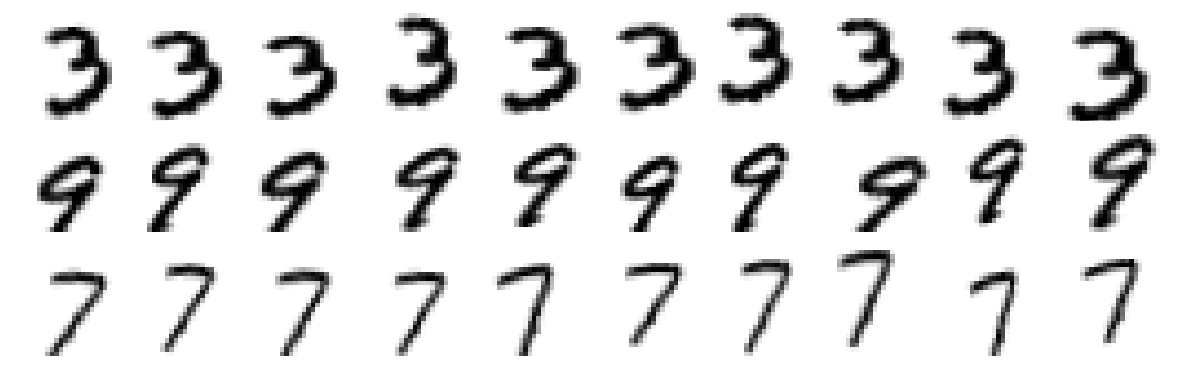

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming X_train and Y_train are defined

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# PREVIEW AUGMENTED IMAGES
X_train3 = X_train[9,].reshape((1, 28, 28, 1))
Y_train3 = Y_train[9,].reshape((1, 10))
plt.figure(figsize=(15, 4.5))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    generator = datagen.flow(X_train3, Y_train3) #create generator object
    X_train2, Y_train2 = next(generator) #use next function on the generator object.
    plt.imshow(X_train2[0].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis('off')
    if i == 9:
        X_train3 = X_train[11,].reshape((1, 28, 28, 1))
    if i == 19:
        X_train3 = X_train[18,].reshape((1, 28, 28, 1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [7]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
import numpy as np

if type(X_train2) is np.ndarray:
    print("X_train2 is a NumPy array.")
else:
    print("X_train2 is not a NumPy array.")

X_train2 is a NumPy array.


In [9]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 45
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) )) 

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


CNN 1: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99500
CNN 2: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99429
CNN 3: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99619
CNN 4: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99667
CNN 5: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99524
CNN 6: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99619
CNN 7: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99476
CNN 8: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99643
CNN 9: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99500
CNN 10: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99738
CNN 11: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99714
CNN 12: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99571
CNN 13: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99429
CNN 14: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99571
CNN 15: Epochs=

In [ ]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) )
for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("./model.csv",index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step


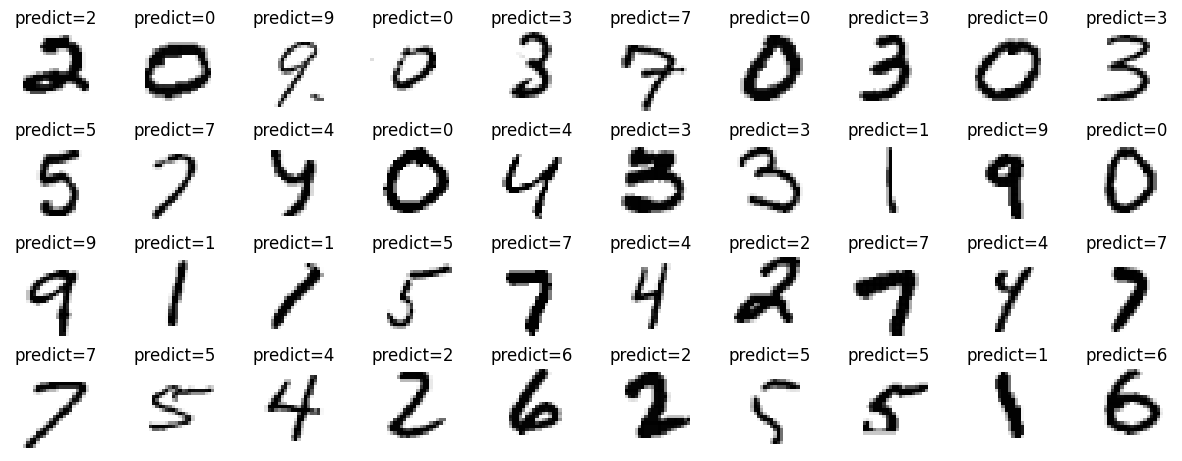

In [11]:
# PREVIEW PREDICTIONS
plt.figure(figsize=(15,6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()